Calculates A matrix given by

$$[A^{pq}_{ij}] = \iint L_p(\xi) L_q(\eta) L_i(\xi) L_j(\eta) J \Big(\frac{x, y}{\xi, \eta} \Big) d\xi d\eta$$

In [2]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))

import numpy as np
from matplotlib import pyplot as plt
import arrayfire as af
af.set_backend('cpu')

from dg_maxwell import utils
from dg_maxwell import lagrange
from dg_maxwell import wave_equation_2d as w2d
from dg_maxwell import msh_parser

plt.rcParams['figure.figsize']     = 12, 7.5
plt.rcParams['lines.linewidth']    = 1.5
plt.rcParams['font.family']        = 'serif'
plt.rcParams['font.weight']        = 'bold'
plt.rcParams['font.size']          = 20  
plt.rcParams['font.sans-serif']    = 'serif'
plt.rcParams['text.usetex']        = True
plt.rcParams['axes.linewidth']     = 1.5
plt.rcParams['axes.titlesize']     = 'medium'
plt.rcParams['axes.labelsize']     = 'medium'

plt.rcParams['xtick.major.size']   = 8
plt.rcParams['xtick.minor.size']   = 4
plt.rcParams['xtick.major.pad']    = 8
plt.rcParams['xtick.minor.pad']    = 8
plt.rcParams['xtick.color']        = 'k'
plt.rcParams['xtick.labelsize']    = 'medium'
plt.rcParams['xtick.direction']    = 'in'    

plt.rcParams['ytick.major.size']   = 8
plt.rcParams['ytick.minor.size']   = 4
plt.rcParams['ytick.major.pad']    = 8
plt.rcParams['ytick.minor.pad']    = 8
plt.rcParams['ytick.color']        = 'k'
plt.rcParams['ytick.labelsize']    = 'medium'
plt.rcParams['ytick.direction']    = 'in'
plt.rcParams['text.usetex']        = True
plt.rcParams['text.latex.unicode'] = True


gmshtranslator friendly reminder: rules and actions prototypes


def node_condition(tag,x,y,z,physgroups): 
def node_action(tag,x,y,z):
def element_condition(eletag,eletype,physgrp,nodes):
def element_action(eletag,eletype,physgrp,nodes):


In [7]:
N_LGL   = 8
xi_LGL  = lagrange.LGL_points(N_LGL)
eta_LGL = lagrange.LGL_points(N_LGL)

N_quad   = N_LGL + 1
xi_quad  = lagrange.LGL_points(N_quad)
eta_quad = lagrange.LGL_points(N_quad)
xi_quad, eta_quad = utils.af_meshgrid(xi_quad, eta_quad)
xi_quad  = af.moddims(xi_quad, d0 = xi_quad.shape[0] * xi_quad.shape[1])
eta_quad = af.moddims(eta_quad, d0 = eta_quad.shape[0] * eta_quad.shape[1])

L_basis_poly1d, L_basis_af = lagrange.lagrange_polynomials(xi_LGL)
L_basis_af = af.np_to_af_array(L_basis_af)

In [8]:
lagrange_basis_index = af.range(N_LGL)
Li_xi  = lagrange.Li_basis_value(L_basis_af, lagrange_basis_index, xi_quad)
Lj_eta = lagrange.Li_basis_value(L_basis_af, lagrange_basis_index, eta_quad)

In [11]:
print(Li_xi.shape)
print(Lj_eta.shape)

(8, 81)
(8, 81)


In [13]:
Li_Lj = utils.outer_prod(Li_xi, Lj_eta)
Li_Lj = af.reorder(af.moddims(Li_Lj, d0 = N_LGL * N_LGL, d1 = 1, d2 = N_quad * N_quad), d0 = 0, d1 = 2, d2 = 1)
Li_Lj.shape

(64, 81)

In [14]:
Lp_Li_Lq_Lj = utils.outer_prod(Li_Lj, Li_Lj)
Lp_Li_Lq_Lj.shape

(64, 64, 81)

In [21]:
nodes, elements = msh_parser.read_order_2_msh('read_and_plot_mesh/mesh/rectangular.msh')
jacobian = w2d.jacobian(nodes[elements[0], 0], nodes[elements[0], 1], xi_quad, eta_quad)
jacobian = af.reorder(jacobian, d0 = 2, d1 = 1, d2 = 0)
jacobian = af.tile(jacobian, d0 = Lp_Li_Lq_Lj.shape[0], d1 = Lp_Li_Lq_Lj.shape[1])
print(jacobian.shape)

gmshTranslator: Initializing...
gmshTranslator: Mesh has 49 nodes.
gmshTranslator: Mesh has 25 elements.
gmshTranslator: Processed 78 lines.
gmshTranslator: There are 1 physical groups available: 
gmshTranslator:      > 0
gmshTranslator: Parsing nodes
gmshTranslator: Parsing elements
gmshTranslator: No rules for elements... skipping elements.
gmshTranslator: Parsing nodes
gmshTranslator: No rules for nodes... skipping nodes.
gmshTranslator: Parsing elements
(64, 64, 81)


In [28]:
# Calculating the gaussian weights

g_weights_xi  = lagrange.gaussian_weights(N_quad)
g_weights_eta = lagrange.gaussian_weights(N_quad)

g_weights_xi_eta = utils.outer_prod(g_weights_xi, g_weights_eta)
g_weights_xi_eta = af.moddims(g_weights_xi_eta, d0 = g_weights_xi_eta.shape[0] * g_weights_xi_eta.shape[1])

In [29]:
print(g_weights_xi_eta.shape)

(81,)


In [30]:
g_weights_xi_eta = af.reorder(g_weights_xi_eta, d0 = 2, d1 = 1, d2 = 0)
g_weights_xi_eta = af.tile(g_weights_xi_eta, d0 = Lp_Li_Lq_Lj.shape[0], d1 = Lp_Li_Lq_Lj.shape[1])
print(g_weights_xi_eta.shape)

(64, 64, 81)


In [36]:
A = af.sum(g_weights_xi_eta * Lp_Li_Lq_Lj * jacobian, dim = 2)

In [38]:
print(A.shape)

(64, 64)


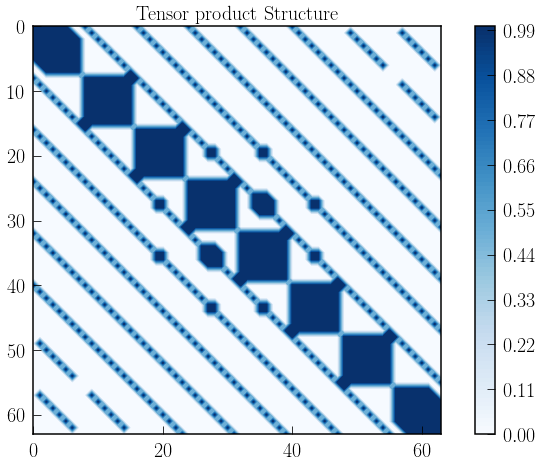

In [51]:
#plot the matrix structure for the matrices.

A_matrix_structure = np.zeros((A.shape[0], A.shape[1]))
threshold = 1e-4
non_zero_indices = np.where(af.abs(A) > threshold)
A_matrix_structure[non_zero_indices] = 1.

plt.gca().invert_yaxis()
plt.contourf(A_matrix_structure, 100, cmap = 'Blues')
plt.axes().set_aspect('equal')
plt.colorbar()
plt.title('Tensor product Structure')
plt.savefig('tensor_product_structure.png')
plt.show()

In [5]:
x = af.range(3, dtype = af.Dtype.u32) + 1
print(x)
x_x = utils.outer_prod(x, x)
print(x_x)
x_x = af.moddims(x_x, x.shape[0] * x.shape[0])
print(x_x)
x_x_x_x = utils.outer_prod(x_x, x_x)
print(x_x_x_x)

arrayfire.Array()
Type: long int

[3 1 1 1]
         1 
         2 
         3 


arrayfire.Array()
Type: long int

[3 3 1 1]
         1          2          3 
         2          4          6 
         3          6          9 


arrayfire.Array()
Type: long int

[9 1 1 1]
         1 
         2 
         3 
         2 
         4 
         6 
         3 
         6 
         9 


arrayfire.Array()
Type: long int

[9 9 1 1]
         1          2          3          2          4          6          3          6          9 
         2          4          6          4          8         12          6         12         18 
         3          6          9          6         12         18          9         18         27 
         2          4          6          4          8         12          6         12         18 
         4          8         12          8         16         24         12         24         36 
         6         12         18         12         24         36       

In [6]:
print(np.outer(x_x, x_x))

[[ 1  2  3  2  4  6  3  6  9]
 [ 2  4  6  4  8 12  6 12 18]
 [ 3  6  9  6 12 18  9 18 27]
 [ 2  4  6  4  8 12  6 12 18]
 [ 4  8 12  8 16 24 12 24 36]
 [ 6 12 18 12 24 36 18 36 54]
 [ 3  6  9  6 12 18  9 18 27]
 [ 6 12 18 12 24 36 18 36 54]
 [ 9 18 27 18 36 54 27 54 81]]


In [13]:
N_quad   = N_LGL + 1
xi_quad  = af.range(N_quad, dtype = af.Dtype.u32)
eta_quad = af.range(N_quad, dtype = af.Dtype.u32)
xi_quad, eta_quad = utils.af_meshgrid(xi_quad, eta_quad)
xi_quad  = af.moddims(xi_quad, d0 = xi_quad.shape[0] * xi_quad.shape[1])
eta_quad = af.moddims(eta_quad, d0 = eta_quad.shape[0] * eta_quad.shape[1])

In [22]:
print(xi_quad)
print(eta_quad)
# for xi, eta in zip(xi_quad, eta_quad):
#     print(np.array(xi)[0], np.array(eta)[0])

arrayfire.Array()
Type: unsigned int

[81 1 1 1]
         0 
         0 
         0 
         0 
         0 
         0 
         0 
         0 
         0 
         1 
         1 
         1 
         1 
         1 
         1 
         1 
         1 
         1 
         2 
         2 
         2 
         2 
         2 
         2 
         2 
         2 
         2 
         3 
         3 
         3 
         3 
         3 
         3 
         3 
         3 
         3 
         4 
         4 
         4 
         4 
         4 
         4 
         4 
         4 
         4 
         5 
         5 
         5 
         5 
         5 
         5 
         5 
         5 
         5 
         6 
         6 
         6 
         6 
         6 
         6 
         6 
         6 
         6 
         7 
         7 
         7 
         7 
         7 
         7 
         7 
         7 
         7 
         8 
         8 
         8 
         8 
         8 
         8 
         8 
   

In [19]:
af.tile?

gmshTranslator: Ending
gmshTranslator: Ending
gmshTranslator: Ending


Signature: af.tile(a, d0, d1=1, d2=1, d3=1)
Docstring:
Tile an array along specified dimensions.

Parameters
----------

a : af.Array.
   Multi dimensional array.

d0: int.
    The number of times `a` has to be tiled along first dimension.

d1: optional: int. default: 1.
    The number of times `a` has to be tiled along second dimension.

d2: optional: int. default: 1.
    The number of times `a` has to be tiled along third dimension.

d3: optional: int. default: 1.
    The number of times `a` has to be tiled along fourth dimension.

Returns
-------

out : af.Array
      An array containing the input after tiling the the specified number of times.

Examples
---------

>>> import arrayfire as af
>>> a = af.randu(2, 3)
>>> b = af.tile(a, 2)
>>> c = af.tile(a, 1, 2)
>>> d = af.tile(a, 2, 2)
>>> af.display(a)
[2 3 1 1]
    0.9508     0.2591     0.7928
    0.5367     0.8359     0.8719

>>> af.display(b)
[4 3 1 1]
    0.4107     0.9518     0.4198
    0.8224     0.1794     0.0081
    0.4107  